In [51]:
import requests
import re
import warnings
import urllib.request
import time
import pyautogui

from webbot import Browser
from selenium import webdriver

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd
import csv
from pandas import DataFrame
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [52]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [53]:
common_words_list = pd.read_csv("Common_Articles_List.csv")
personality = pd.read_csv("Personality.csv", sep=',')
software = pd.read_csv("Programming_Languages.csv")

common = common_words_list["word"].to_list()
personality = [x.lower() for x in personality["Traits"]]
software = [x.lower() for x in software["languages"]]
education = ["highschool", "ged", "bachelors", "masters", "phd", "internship"]

In [54]:
def chrome_engine(job, area):
    
    """Uses selenium to open a chrome browser to Indeed.com. It then uses pyautogui to input user area and job title
       inside input then submits search in order to capture that unique url we will use for analysis"""
    
    driver = webdriver.Chrome()
    driver.get('https://indeed.com/')

    time.sleep(3)
    pyautogui.press(['tab'] * 13) # First search button
    time.sleep(2)
    pyautogui.typewrite(job) # Insert job title
    time.sleep(2)
    pyautogui.press(['tab'] * 2) # Select 2nd location box
    time.sleep(2)
    pyautogui.typewrite(area) # Type location of search
    time.sleep(3)
    pyautogui.press('enter')
    time.sleep(3)

    current_page_url = driver.current_url
    driver.close()
    
    return current_page_url

In [55]:
def get_indeed_page_numbers(page):
    
    """This Function is called when the total number of job posting pages is greater than 4. Collects additional page 
       hyperlinks in groups of 2 until it reaches the maximum number of pages generated. Returns a list of page links greater 
       than 4 on an indeed search result page """
    
    clock = False
    page_numbers_element = page.find_all("span", class_="pn", text=True)

    page_number_list = []
    for items in page_numbers_element:
        page_number_list.append("https://www.indeed.com" + items.parent["href"])
    
    if len(page_numbers_element) == 4:
        
        loop_counter = 5
        
        while clock is False:
            last_page = page_number_list[-1]
            analysis_page = requests.get(last_page)
            soup = BeautifulSoup(analysis_page.content, "html.parser")
            new_link_list = soup.find_all("span", class_="pn", text=True)
            
            try:
                additional_counter = int(new_link_list[-1].text) - loop_counter
            
                if additional_counter < 1: 
                    clock = True

                else: 
                    for items in new_link_list[(additional_counter * -1):]:
                        loop_counter = int(items.text)
                        page_number_list.append("https://www.indeed.com" + items.parent["href"])
                    clock = False
                    
            except IndexError:
                clock = True
        
        
    return page_number_list

In [56]:
def indeed_page_web_scrapper(current_page_url):
    
    """Once Base Link Generated, This Function uses beautiful soup to get the total number of pages of job postings available 
       and collects each page number's hyperlink scraped from its html element. Calls additional_page_links function
       when the number of pages is greater than 4. Returns a list of page links generated on an indeed result page"""
    
    indeed_url = "https://www.indeed.com"

    analysis_page = requests.get(current_page_url)
    soup = BeautifulSoup(analysis_page.content, "html.parser")


    additional_page_links = get_indeed_page_numbers(soup)

    print(len(additional_page_links), " Potential Pages of Job Postings")




    job_links = []    
    job_listings = soup.find_all('a', class_="tapItem")
    counter = 0
    for job in job_listings:
        job_links.append(indeed_url + job["href"])


    for page_link in additional_page_links:
        web_page = requests.get(page_link)
        soup = BeautifulSoup(web_page.content, "html.parser")
        job_listings = soup.find_all('a', class_="tapItem")


        for job in job_listings:
            job_links.append(indeed_url + job["href"])


    print("Total Jobs Analyzed: ", len(job_links))
    print("   ")
    return job_links

In [57]:
def job_description_page(job_links):
    
    """Takes a list of job pages, and scrapes all job descriptions generated per link in job_links. Appends each job 
       description into a list for further analysis. Returns a list of job descriptions in text form"""
    
    print("Analyzing Job Descriptions")
    counter = 0
    page_body_text = []

    for job_page in job_links:
        loaded_page = requests.get(job_page)
        soup = BeautifulSoup(loaded_page.text, "html.parser")


        page_body = soup.find_all("div", class_="jobsearch-JobComponent-description")

        for elements in page_body:
            text = elements.get_text()

            page_body_text.append(text)
            counter += 1
            
    print("Total Job Descriptions Readable: ", len(page_body_text))
    print("   ")
    return page_body_text

In [58]:
def job_description_cleaner(page_body_text):
    
    """Takes a list of job descriptions and uses various filtering tools such as premade lists in order to clean and reformat
       words for further analysis and counting. Returns a list of words generated from all the descriptions passed down"""
    
    print("Cleaning Out Format Of Words!")
    counter = 0
    unwanted_chars = [" ", ",", "/", "'\'", ".", "(", ")", ";", '"', "'", ":", "-", "_", 
                      "&", "[", "]", "*", "?", "#", "!", "%", "®", "“", '”', ":", "~"]

    additional_splitting = ["/", "(", ")", "%", "/", ".", "-", "/"]
    final_list = []
    word_frequency = {}

    for items in page_body_text:
        if items is not None:
            text = re.sub("\n", " ", items)
            clean_list = text.split()

            for word in clean_list:
                split_words = []
                if word != "":

                    if len(word) > 1:

                        cleaned = False
                        while cleaned is False:

                            if len(word) > 1 and word[len(word)-1] in unwanted_chars:
                                word = word[:-1]

                                if len(word) > 1 and word[0] in unwanted_chars:
                                    word = word[1:]


                            if len(word) > 1 and word[0] in unwanted_chars:
                                word = word[1:]

                                if len(word) > 1 and word[len(word)-1] in unwanted_chars:
                                    word = word[:-1]


                            if len(word) == 1:
                                if word in unwanted_chars:
                                    cleaned = True

                                else:
                                    final_list.append(word.lower().strip())
                                    cleaned = True

                            elif word[0] not in unwanted_chars and word[len(word) - 1] not in unwanted_chars:
        
                                if word[-2:] == "'s" or word[-2:] == "’s":
                                    word = word[:-2] + "s"

                                if "$" in word:
                                    word = "$" + word.split("$", 1)[1]

                                for symbols in additional_splitting:
                                    if symbols in word: 
                                        split_words = word.split(symbols)

                                if len(split_words) == 0: 
                                    final_list.append(word.lower().strip())
                                    cleaned = True
                                else: 
                                    for words in split_words:
                                        final_list.append(words.lower().strip())
                                        cleaned = True

                            else: 
                                cleaned = False

                    else: 
                        if word not in unwanted_chars:
                            final_list.append(word.lower().strip())
        
        else: 
            continue


    print("Total Words For Analysis: ",len(final_list))
    print("   ")
    return final_list

In [59]:
def word_counter(final_list):
    
    """Takes a list of words, and created a blank dictionary that counts the frequencies of each words filtered out. 
    Word Frequency dictonary is then reorganized into a list based on frequency count and returns a list of sorted words"""

    word_frequency= {}
    for words in final_list:
        if words not in word_frequency:
            word_frequency[words] = 1
        else:
            word_frequency[words] += 1

    for words in common: 
        if words in word_frequency.keys():
            del word_frequency[words]

    sorted_word_frequency_list = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
    return sorted_word_frequency_list

In [60]:
def analytics(sorted_word_frequency_list):
    
    """Takes a list of sorted word frequencies and further filters and categorizes words based on web-generated excel lists
       and personally designed filtering lists. Returns currently 4 lists. Programming languages, Personality Traits, 
       Salary Expectations, and Educational Experience."""
    
    programming_languages = []
    personality_traits = []
    salary_expectations = []
    experience = []
    

    for items in sorted_word_frequency_list: 
        if items[0] in software:
            programming_languages.append(items)

        if items[0] in personality:
            personality_traits.append(items)

        if items[0] in education:
            experience.append(items)

        elif "$" in items[0] and len(items[0]) > 1:
            try:
                if "k" in items[0] and "-" not in items[0]: 
                    money = items[0]
                    money = int(money[1:-1])
                    money = "$" + str(money) + ",000"
                    salary_expectations.append((money, items[1]))
                    continue
                    
            except ValueError:
                continue
                    
            if len(items[0]) <= 3 and len(items[0]) > 2:
        
                money = items[0]

                try:
                    money = int(money[1:])
                    money = "$" + str(f'{(money * 40 * 52):,}')
                    salary_expectations.append((money, items[1]))
                except ValueError:
                        continue

            

            else:
                if len(items[0]) <= 2:
                    continue
                else:
                    try:
                        money = items[0]
                        money = int(money[1:].replace(",", ""))
                        salary_expectations.append((items[0], items[1]))
                    except ValueError:
                        continue

    return programming_languages, personality_traits, salary_expectations, experience

In [61]:
def csv_writer(sorted_word_frequency_list):
    
    """Takes a list of sorted words and writes on an empty csv file fore SQL querying and Tableau Visualizations"""
    
    with open ("Word_Frequency.csv", "w", encoding="UTF8") as f:
        writer = csv.writer(f)
        for items in sorted_word_frequency_list:
            writer.writerrow([items[0], items[1]])

In [62]:
def programming_lang_bar_chart(programming_lang):
    
    """Generates a bar chart based on popular programming languages"""
    
    programming_lang = visualization_lists[0]
    index = []
    value = []
    for items in programming_lang:
        index.append(items[0])
        value.append(items[1])

    plt.figure(figsize=(28,15))
    plt.title("Frequency of Programming/Querying Languages Mentioned in Job Descriptions")

    ax = sns.barplot(x=index, y=value)
    ax.bar_label(ax.containers[0])
    plt.show

In [63]:
def personality_donut_plot(personality_list):
    
    """Generates a donut plot based on popular personality traits and characteristics"""
    
    def make_autopct(value):
        def my_autopct(pct):
            total = sum(value)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_autopct

    index = []
    value = []

    for items in personality_list:
        index.append(items[0])
        value.append(items[1])

    plt.figure(figsize=(20,20))
    plt.title("Top 25 Personality Trait Frequency")
    plt.pie(value[:25], 
            labels=index[:25], 
            autopct=make_autopct(value), 
            shadow=True, 
            startangle=140,
            wedgeprops={"linewidth": 3.0, "edgecolor": "black"},
            textprops={"size": "18", "color": "black",},
            pctdistance=.85)

    my_circle = plt.Circle((0,0), .7, color="black")
    my_2circle = plt.Circle((0,0), .69, color="white")

    black_circle =plt.gcf()
    white_circle=plt.gcf()
    black_circle.gca().add_artist(my_circle)
    white_circle.gca().add_artist(my_2circle)

    plt.show

In [64]:
def salary_bar_chart(salary_expectations):
    
    """Generates a bar chart based on wages mentioned in job descriptions"""
    
    data_value_list = []
    new_salary_expectations = []
    index = []
    value = []
    money_groups = {
        "~10k Annually": 0,
        "10k Annually": 0,
        "20k Annually": 0,
        "30k Annually": 0,
        "40k Annually": 0,
        "50k Annually": 0,
        "60k Annually": 0,
        "70k Annually": 0,
        "80k Annually": 0,
        "90k Annually": 0,
        "100k Annually": 0,
        "110k Annually": 0,
        "120k Annually": 0,
        "130k Annually": 0,
        "140k Annually": 0,
        "150k Annually": 0,
        "160k Annually": 0,
        "170k Annually": 0,
        "180k Annually": 0,
        "190k Annually": 0,
        "200k Annually": 0,
        "200k+ Annually": 0,
    }

    for items in salary_expectations:
        try:
            money = items[0]
            money = int(money[1:].replace(",", ""))

            if money < 10000: money_groups["~10k Annually"] += items[1]
            if 10000 <= money < 20000: money_groups["10k Annually"] += items[1]
            if 20000 <= money < 30000: money_groups["20k Annually"] += items[1]
            if 30000 <= money < 40000: money_groups["30k Annually"] += items[1]
            if 40000 <= money < 50000: money_groups["40k Annually"] += items[1]
            if 50000 <= money < 60000: money_groups["50k Annually"] += items[1]
            if 60000 <= money < 70000: money_groups["60k Annually"] += items[1]
            if 70000 <= money < 80000: money_groups["70k Annually"] += items[1]
            if 80000 <= money < 90000: money_groups["80k Annually"] += items[1]
            if 90000 <= money < 100000: money_groups["90k Annually"] += items[1]
            if 100000 <= money < 110000: money_groups["100k Annually"] += items[1]
            if 110000 <= money < 120000: money_groups["110k Annually"] += items[1]
            if 120000 <= money < 130000: money_groups["120k Annually"] += items[1]
            if 130000 <= money < 140000: money_groups["130k Annually"] += items[1]
            if 140000 <= money < 150000: money_groups["140k Annually"] += items[1]
            if 150000 <= money < 160000: money_groups["150k Annually"] += items[1]
            if 160000 <= money < 170000: money_groups["160k Annually"] += items[1]
            if 170000 <= money < 180000: money_groups["170k Annually"] += items[1]
            if 180000 <= money < 190000: money_groups["180k Annually"] += items[1]
            if 190000 <= money < 200000: money_groups["190k Annually"] += items[1]
            if 200000 <= money: money_groups["200k+ Annually"] += items[1]

        except ValueError:
            continue

    for items in money_groups.items():
        index.append(items[0])
        value.append(items[1])


    plt.figure(figsize=(25,25))
    plt.title("Frequency of Salary Expectations Mentioned in Job Descriptions")
    ax = sns.barplot(x=index, y=value)
    ax.bar_label(ax.containers[0])
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.show

In [65]:
def education_pie_chart(education):
    
    """Generates a pie chart based on educational requirements mentioned in each description"""
    
    index = []
    value = []
    for items in education: 
        index.append(items[0])
        value.append(items[1])

    def make_autopct(value):
        def my_autopct(pct):
            total = sum(value)
            val = int(round(pct*total/100.0))
            return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
        return my_autopct

    length = len(index)

    colors = ["pink", "maroon", "red", "gray", "gray", "gray"]
    colors = colors[:-(len(colors) - length)]
    explode= [0.1, 0, 0.1, 0.2, .3, 0.6, 1.3]
    explode = explode[len(explode)- length:]

    fig, ax = plt.subplots(figsize=(10,10))

    patches, texts, pcts = ax.pie ( 
        value, labels=index, autopct=make_autopct(value), 
        wedgeprops={"linewidth": 3.0, "edgecolor": "black"},
        textprops={"size": "18", "color": "black",},
        startangle=40, 
        pctdistance=0.6,
        shadow = True,
        colors = colors,
        explode=explode)

    ax.set_title("Job Educational Requirements Frequency", fontsize = 18)

In [67]:
def main():
    job = input("Job Title?: ")
    area = input("Location of Search (ex. Washington, DC): ")


    current_page_url = chrome_engine(job, area)

    job_links = indeed_page_web_scrapper(current_page_url)

    page_body_text = job_description_page(job_links)

    #final_list = job_description_cleaner(page_body_text)

    #sorted_word_frequency_list = word_counter(final_list)

    #visualization_lists = analytics(sorted_word_frequency_list)
    
    print("Data Collection Complete, Ready For Visualization")
    return page_body_text


In [ ]:
visualization_lists = main()

In [71]:
visualization_lists

[]

In [95]:
driver = webdriver.Chrome()
driver.get('https://www.ziprecruiter.com/jobseeker/home')

https://www.indeed.com/jobs?q=data+analyst&l=washington%2C+dc&from=searchOnHP&vjk=50508f88ecc0ce66


In [91]:
import requests

current_page_url = 'https://www.ziprecruiter.com/jobs-search?landed_from=suggested_jobs_blank_search&search=data+analyst&location=Washington%2C+DC&autocomplete_request_id=Uqbt5U5oT5CW2vzwnKShTQ'

# Define headers to mimic a browser
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

req = requests.get(current_page_url, headers)
soup = BeautifulSoup(req.content, 'html.parser')
print(soup)

<!DOCTYPE html>
<html lang="en-US"><head><title>Just a moment...</title><meta content="text/html; charset=utf-8" http-equiv="Content-Type"/><meta content="IE=Edge" http-equiv="X-UA-Compatible"/><meta content="noindex,nofollow" name="robots"/><meta content="width=device-width,initial-scale=1" name="viewport"/><style>*{box-sizing:border-box;margin:0;padding:0}html{line-height:1.15;-webkit-text-size-adjust:100%;color:#313131}button,html{font-family:system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji}@media (prefers-color-scheme:dark){body{background-color:#222;color:#d9d9d9}body a{color:#fff}body a:hover{color:#ee730a;text-decoration:underline}body .lds-ring div{border-color:#999 transparent transparent}body .font-red{color:#b20f03}body .big-button,body .pow-button{background-color:#4693ff;color:#1d1d1d}body #challenge-success-text{background-image:url()}body #challenge-error

In [ ]:
soup = BeautifulSoup(analysis_page.content, "html.parser")


additional_page_links = get_indeed_page_numbers(soup)

print(len(additional_page_links), " Potential Pages of Job Postings")




job_links = []    
job_listings = soup.find_all('a', class_="tapItem")
counter = 0
for job in job_listings:
    job_links.append(indeed_url + job["href"])


for page_link in additional_page_links:
    web_page = requests.get(page_link)
    soup = BeautifulSoup(web_page.content, "html.parser")
    job_listings = soup.find_all('a', class_="tapItem")


    for job in job_listings:
        job_links.append(indeed_url + job["href"])


print("Total Jobs Analyzed: ", len(job_links))
print("   ")
#return job_links

In [89]:
programming_lang_bar_chart(visualization_lists[0])

IndexError: list index out of range

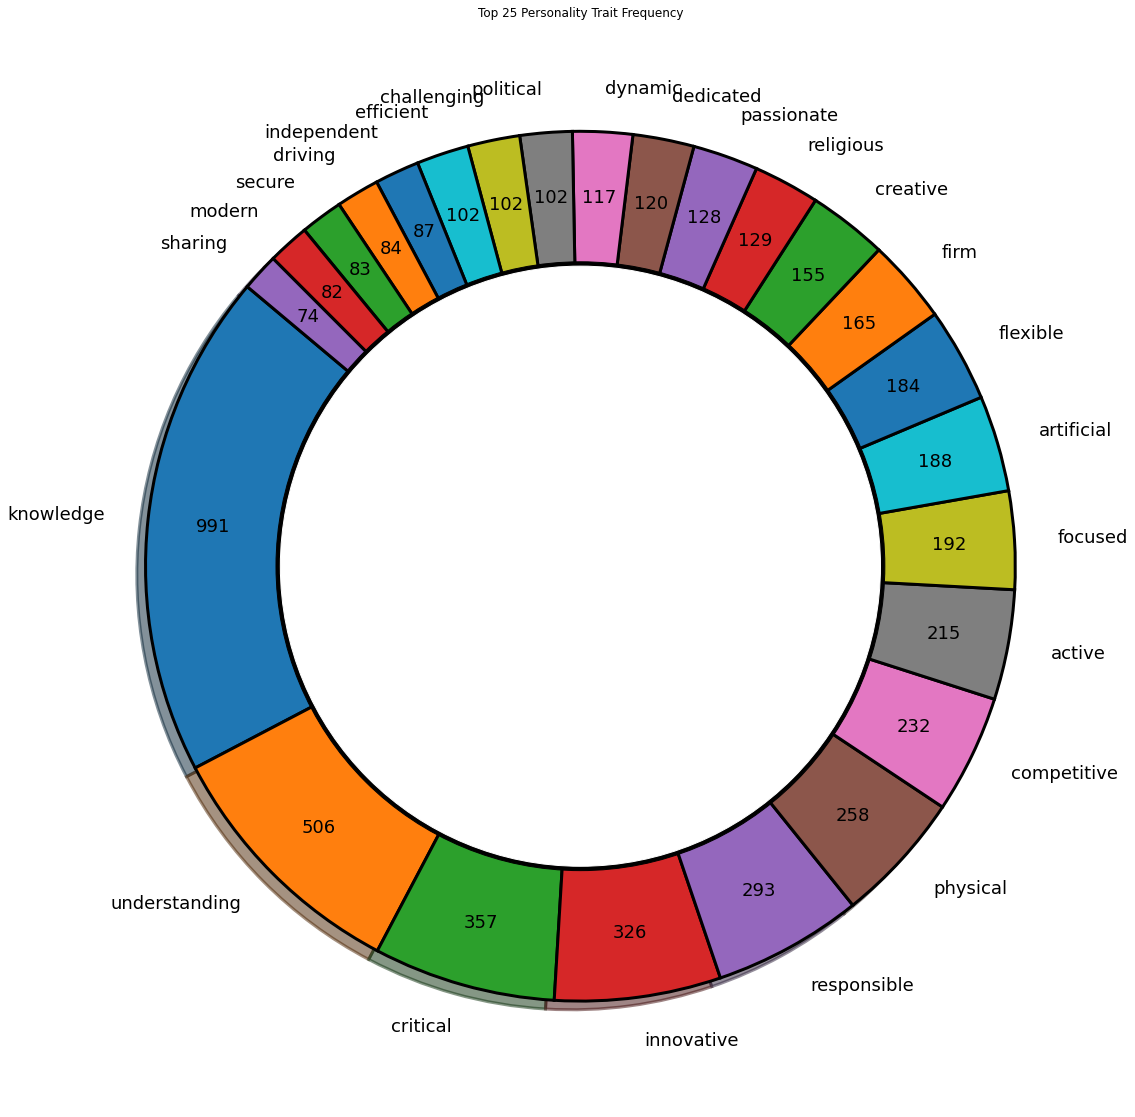

In [134]:
personality_donut_plot(visualization_lists[1])

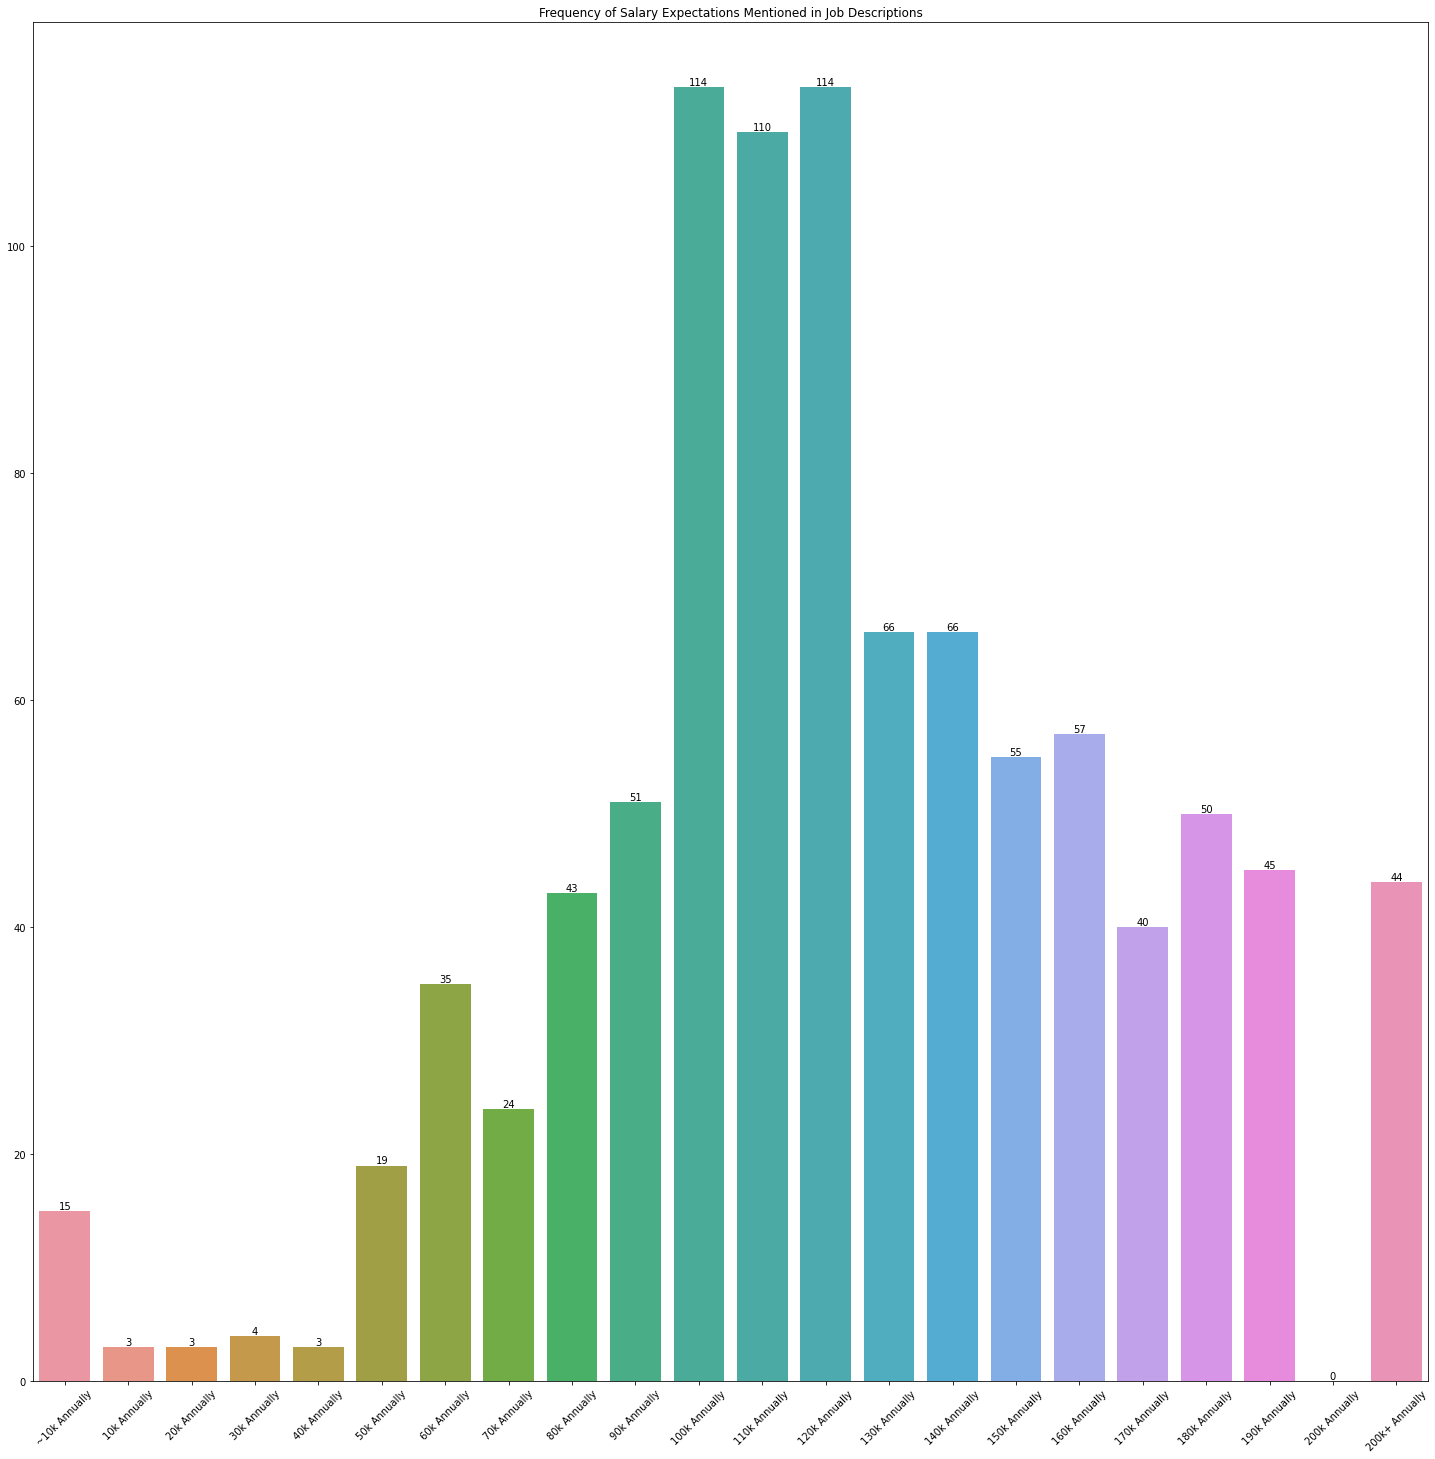

In [137]:
salary_bar_chart(visualization_lists[2])

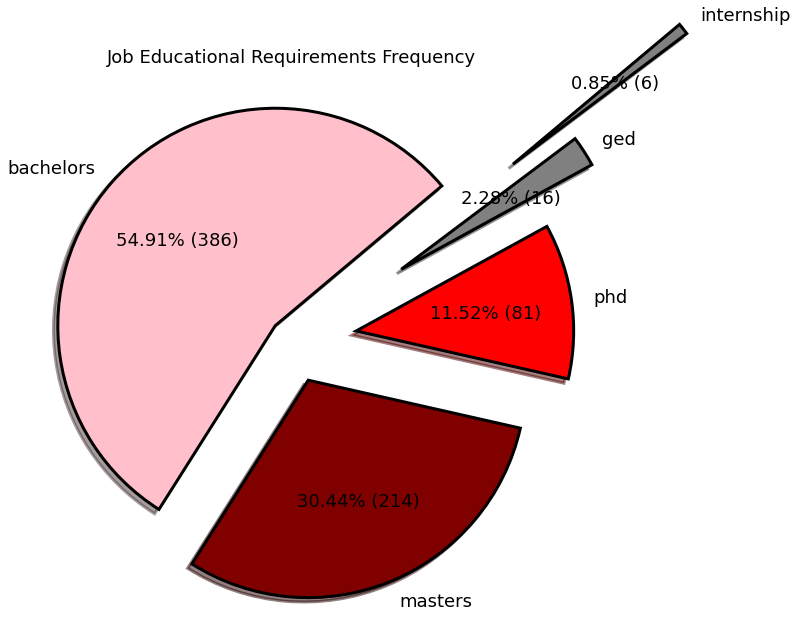

In [132]:
education_pie_chart(visualization_lists[3])

In [90]:
l=[]
o={}
target_url = "https://www.indeed.com/jobs?q=python&l=New+York%2C+NY&vjk=8bf2e735050604df"
head= {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
    "Connection": "keep-alive",
    "Accept-Language": "en-US,en;q=0.9,lt;q=0.8,et;q=0.7,de;q=0.6",
}
resp = requests.get(target_url, headers=head)

SyntaxError: invalid syntax (617853353.py, line 1)